프로젝트 개요

이 프로젝트에서는 Credit Default Risk로 과거 대출 신청 데이터를 사용하여 신청자가 대출금을 상환할 수 있는지 여부를 예측해 보았습니다.

대출금 상환 여부를 예측하기 위해 본 프로젝트에서는 KNN, Logistic Regression, Decision Tree 및 인기가 많은 XGBoost 총 4개의 알고리즘을 활용하여 예측력은 가장 좋은 알고리즘 즉 XGBoost 알고리즘을 확인하였습니다.

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))      # list all files under the input directory

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


# 변수 탐색

In [2]:
credit_df = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')

In [3]:
credit_df.shape

(32581, 12)

In [4]:
credit_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


**변수 설명**
* person_age:                  age
* person_income:               annual income
* person_home_ownership:       home ownership 
* person_emp_length:          employment length(in years)
* loan_intent:                 loan intent 
* loan_grade:                  loan grade 
* loan_amnt:                   loan amount 
* loan_int_rate:               interest rate
* loan_status:                 loan status(0: non default, 1: default) 
* loan_percent_income:         percent income
* cb_person_default_on_file:   historical default
* cb_person_cred_hist_length:  credit history length


In [5]:
credit_df['person_home_ownership'].value_counts()

RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64

In [6]:
credit_df['loan_intent'].value_counts()

EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64

In [7]:
credit_df['loan_grade'].value_counts()   # A ~ G

A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64

In [8]:
credit_df['cb_person_default_on_file'].value_counts()  # no/yes

N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64

In [9]:
credit_df['loan_status'].value_counts()  # 0 (non default)or 1 (default)

0    25473
1     7108
Name: loan_status, dtype: int64

In [10]:
credit_df.describe()  # 이상치 확인

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


1. person_age 칼럼 최대값 이상치로 보임
2. person_emp_length 칼럼 최대값 이상치로 보임 
3. person_income 칼럼 최대값 이상치인지 추가 확인 필요


In [11]:
df_num = credit_df.select_dtypes(['float', 'int'])
df_hist = df_num.drop(['loan_status'], axis=1)

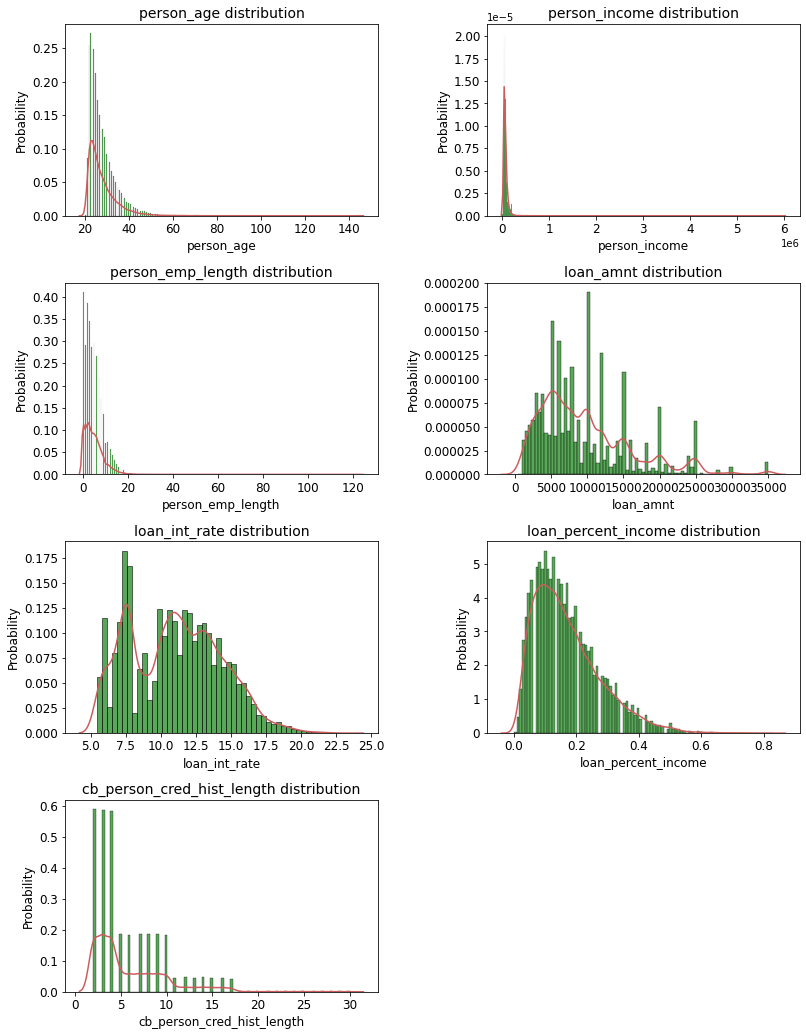

In [12]:
#y변수(loan_status) 제외한 x변수를 대상으로 시각화

plt.figure(figsize=(12,16))
for i, column in enumerate(df_hist.columns):
    plt.subplot(int('42'+str(i+1)))
    sns.histplot(df_hist[column], color='forestgreen', stat='density')
    sns.kdeplot(df_hist[column], color='indianred')
    plt.title(column +' distribution',fontsize=14)
    plt.ylabel('Probability', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
plt.show()

In [13]:
credit_df['person_income'].sort_values(ascending=False)  

32297    6000000
30049    2039784
32546    1900000
32497    1782000
31924    1440000
          ...   
15961       4800
15963       4200
27896       4200
15964       4080
31930       4000
Name: person_income, Length: 32581, dtype: int64

In [14]:
credit_df['person_emp_length'].sort_values(ascending=False) 

0        123.0
210      123.0
32355     41.0
32515     38.0
32428     34.0
         ...  
32285      NaN
32328      NaN
32360      NaN
32453      NaN
32471      NaN
Name: person_emp_length, Length: 32581, dtype: float64

1. 이상치(person_age > 100) 삭제할 예정
2. 이상치(person_emp_length 최대값) 삭제할 예정
3. 이상치(person_income 최대값) 삭제할 예정

In [15]:
nan_per = credit_df.isnull().sum() / credit_df.shape[0]*100  # 결측치 확인 
nan_per.round(2)

person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
person_emp_length             2.75
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_int_rate                 9.56
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

person_emp_length 및 loan_int_rate 칼럼에 결측치 있음, 각각 2.75%, 9.56% 차지하고 있음

결측치를 대체하기 위해 결측치 해당 칼럼의 최빈수와 평균값을 확인

In [16]:
print('person_emp_length 최빈수 = {}'.format(credit_df['person_emp_length'].mode()[0]))
print('person_emp_length 평균값 = {}'.format(credit_df['person_emp_length'].mean()))
print('loan_int_rate 최빈수 = {}'.format(credit_df['loan_int_rate'].mode()[0]))
print('loan_int_rate 평균값 = {}'.format(credit_df['loan_int_rate'].mean()))

person_emp_length 최빈수 = 0.0
person_emp_length 평균값 = 4.789686296787225
loan_int_rate 최빈수 = 7.51
loan_int_rate 평균값 = 11.011694892245036


person_emp_length(근로기간)의 경우 결측치를 최빈수로, loan_int_rate(금리)의 경우 결측치를 평균값으로 대체할 예정입니다. 

# 데이터 전처리

### 결측치 처리

In [17]:
credit_df['person_emp_length'].fillna(credit_df['person_emp_length'].mode()[0], inplace=True)
credit_df['loan_int_rate'].fillna(credit_df['loan_int_rate'].mean(), inplace=True)

In [18]:
credit_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

### 이상치 처리

In [19]:
credit_df = credit_df[credit_df['person_age']<=100]
credit_df = credit_df[credit_df['person_income'] < credit_df['person_income'].max()]
credit_df = credit_df[credit_df['person_emp_length'] < credit_df['person_emp_length'].max()]

In [20]:
credit_df.shape

(32573, 12)

In [21]:
corr = credit_df.corr()['loan_status'].sort_values(ascending=False)
corr

loan_status                   1.000000
loan_percent_income           0.379241
loan_int_rate                 0.319310
loan_amnt                     0.105238
cb_person_cred_hist_length   -0.015436
person_age                   -0.020651
person_emp_length            -0.090431
person_income                -0.171638
Name: loan_status, dtype: float64

loan_percent_income, loan_int_rate: 종속변수 loan_status에 긍정적인 영향을 미치며,변수값이 클수록 credit risk 높아집니다.

person_income: 기본이 되는 loan_status에 부정적인 영향을 미치며, 변수값이 클수록 credit risk 적어집니다.

### 데이터 인코딩

In [22]:
credit_df_encoded = pd.get_dummies(credit_df, drop_first=True)  # one_hot encoding
credit_df_encoded.shape

(32573, 23)

In [23]:
credit_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 1 to 32580
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   32573 non-null  int64  
 1   person_income                32573 non-null  int64  
 2   person_emp_length            32573 non-null  float64
 3   loan_amnt                    32573 non-null  int64  
 4   loan_int_rate                32573 non-null  float64
 5   loan_status                  32573 non-null  int64  
 6   loan_percent_income          32573 non-null  float64
 7   cb_person_cred_hist_length   32573 non-null  int64  
 8   person_home_ownership_OTHER  32573 non-null  uint8  
 9   person_home_ownership_OWN    32573 non-null  uint8  
 10  person_home_ownership_RENT   32573 non-null  uint8  
 11  loan_intent_EDUCATION        32573 non-null  uint8  
 12  loan_intent_HOMEIMPROVEMENT  32573 non-null  uint8  
 13  loan_intent_MEDI

### train set / test set 준비

In [24]:
X = credit_df_encoded.drop(['loan_status'], axis=1)
y = credit_df_encoded['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(22801, 22) (9772, 22) (22801,) (9772,)


### 모델 생성

In [25]:
# 모델 생성하기 전에 모델 평가를 위한 함수 정의
def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(name, '\n', classification_report(y_test, pred))

In [26]:
# KNN
knn = KNeighborsClassifier()
model_assess(knn, name='KNN')

# Logistic Regression
lg = LogisticRegression(random_state=42)
model_assess(lg, name = 'Logistic Regression')

# DecisionTree Classifier
dr = DecisionTreeClassifier(random_state=42)
model_assess(dr, name = 'DecisionTree Classifier')

# XGBoost
xgb = XGBClassifier(objective="binary:logistic", random_state=42)
model_assess(xgb, name = 'XGBClassifier')

KNN 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      7606
           1       0.66      0.50      0.57      2166

    accuracy                           0.83      9772
   macro avg       0.76      0.71      0.73      9772
weighted avg       0.82      0.83      0.82      9772

Logistic Regression 
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      7606
           1       0.72      0.16      0.26      2166

    accuracy                           0.80      9772
   macro avg       0.76      0.57      0.57      9772
weighted avg       0.79      0.80      0.75      9772

DecisionTree Classifier 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      7606
           1       0.76      0.77      0.77      2166

    accuracy                           0.90      9772
   macro avg       0.85      0.85      0.85      9772
weighted avg       0

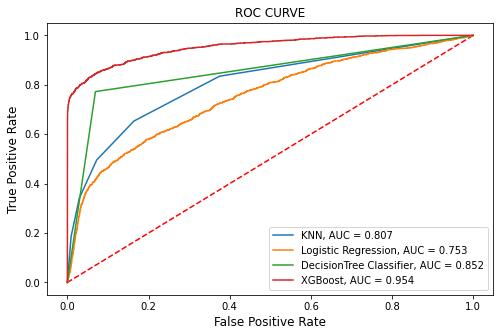

In [27]:
# AUC
fig = plt.figure(figsize=(8,5))
plt.plot([0,1], [0,1], 'r--')

# KNN
knn_preds_proba = knn.predict_proba(X_test)
knn_default_proba = knn_preds_proba[:, 1]
fpr, tpr, threshold = roc_curve(y_test, knn_default_proba)
knn_score = roc_auc_score(y_test, knn_default_proba)
plt.plot(fpr, tpr, label=f'KNN, AUC = {str(round(knn_score, 3))}')

# Logistic Regression
lg_preds_proba = lg.predict_proba(X_test)
lg_default_proba = lg_preds_proba[:, 1]
fpr, tpr, threshold = roc_curve(y_test, lg_default_proba)
lg_score = roc_auc_score(y_test, lg_default_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(lg_score,3))}')

# DecisionTree Classifier
dr_preds_proba = dr.predict_proba(X_test)
dr_default_proba = dr_preds_proba[:, 1]
fpr, tpr, threshold = roc_curve(y_test, dr_default_proba)
dr_score = roc_auc_score(y_test, dr_default_proba)
plt.plot(fpr, tpr, label=f'DecisionTree Classifier, AUC = {str(round(dr_score,3))}')

# XGBoost
xgb_preds_proba = xgb.predict_proba(X_test)
xgb_default_proba = xgb_preds_proba[:, 1]
fpr, tpr, threshold = roc_curve(y_test, xgb_default_proba)
xgb_score = roc_auc_score(y_test, xgb_default_proba)
plt.plot(fpr, tpr, label = f'XGBoost, AUC = {str(round(xgb_score, 3))}')
plt.ylabel("True Positive Rate", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [28]:
feature_importance = pd.DataFrame({'feature': X_test.columns, 'importance': xgb.feature_importances_})
feature_importance_sorted = feature_importance.sort_values(['importance'], ascending=False)





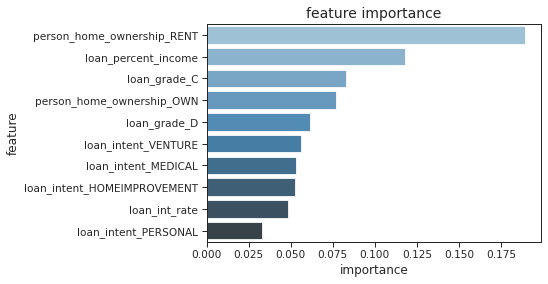

In [29]:
sns.set(context='paper', style='ticks', font='sans-serif',
       font_scale=1.2, color_codes=True, rc=None)
plt.plot(figsize=(8,5))
sns.barplot(data=feature_importance_sorted[:10], y='feature', 
           x = 'importance', palette='Blues_d')
plt.title('feature importance',fontsize = 14)
plt.xlabel('importance', fontsize=12)
plt.ylabel('feature', fontsize=12)
plt.show()


XGBoost 모델은 KNN, LogisticRegression 및 DecisionTree 분류기에 비해 AUROC점수 0.954로 최고의 성능을 보입니다.